--2021-05-02 00:39:31--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.12.128, 108.177.13.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M   104MB/s    in 1.8s    

2021-05-02 00:39:33 (104 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]

--2021-05-02 00:39:33--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.123.128, 64.233.170.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.123.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tm

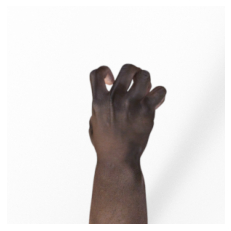

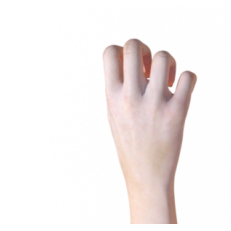

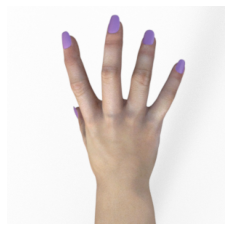

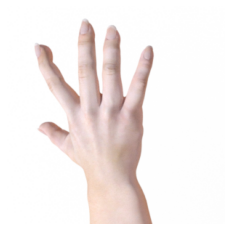

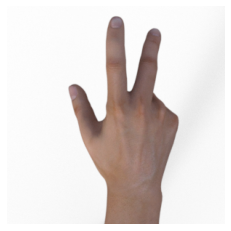

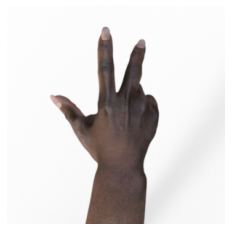

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_______________________________________

In [1]:
"""
CS478 Assignment 5:
Create a webserver and client for a ML inference system.
(This is the file in which I did my model training and saved the file as
"model.h5")

Taylor Fernandez
"""
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import os
import zipfile
from google.colab import files
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip
  
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

#training dataset
local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

#test dataset
local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

rock_dir = os.path.join('/tmp/rps/rock')
paper_dir = os.path.join('/tmp/rps/paper')
scissors_dir = os.path.join('/tmp/rps/scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

pic_index = 12

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  #print(img_path)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

  TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)


# "class_mode = categorical" is needed for multi class 
train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical'
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(train_generator, epochs=25, validation_data = validation_generator, verbose = 1)
model.save("model.h5")
